In [34]:
import re
import platform

if re.search("Intel", platform.processor()):
    from sklearnex import patch_sklearn

    print("Intel CPU DETECTED!")
    patch_sklearn()
import pandas as pd

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

%matplotlib inline

# Data Preprocessing

In [35]:
data = pd.read_csv('./Traffic_accidents.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4265 entries, 0 to 4264
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   OBJECTID              4265 non-null   int64 
 1   DATE_                 4265 non-null   object
 2   TIME                  4265 non-null   int64 
 3   SEVERITY              4265 non-null   int64 
 4   SEVERITY_DESCRIPTION  4265 non-null   object
 5   ACCIDENT_TYPE         4265 non-null   object
 6   ACCIDENT_DESCRIPTION  4265 non-null   object
 7   VEHICLES              4265 non-null   int64 
 8   CASUALTIES            4265 non-null   int64 
 9   PEDESTRIAN            4265 non-null   int64 
 10  CYCLES                4265 non-null   int64 
 11  MCYCLES               4265 non-null   int64 
 12  CHILDREN              4265 non-null   int64 
 13  OAPS                  4265 non-null   int64 
 14  X                     4265 non-null   int64 
 15  Y                     4265 non-null   

In [36]:
data.head(3)

OBJECTID                   DATE_  TIME  SEVERITY SEVERITY_DESCRIPTION  \
0         1  2017/02/02 00:00:00+00   720         3               Slight   
1         2  2017/02/02 00:00:00+00  1803         3               Slight   
2         3  2017/02/03 00:00:00+00  2021         3               Slight   

  ACCIDENT_TYPE                      ACCIDENT_DESCRIPTION  VEHICLES  \
0            LC                           Loss of Control         2   
1             J  Turning movement ¿ unidentified priority         2   
2            J2          Turning Movement from minor road         2   

   CASUALTIES  PEDESTRIAN  CYCLES  MCYCLES  CHILDREN  OAPS       X       Y  \
0           2           0       1        1         0     0  360035  175918   
1           1           0       1        0         0     0  359039  172053   
2           1           0       1        0         0     0  362596  175377   

  RENDER  
0    CYC  
1    CYC  
2    CYC

In [37]:
data.isnull().sum()

OBJECTID                0
DATE_                   0
TIME                    0
SEVERITY                0
SEVERITY_DESCRIPTION    0
ACCIDENT_TYPE           0
ACCIDENT_DESCRIPTION    0
VEHICLES                0
CASUALTIES              0
PEDESTRIAN              0
CYCLES                  0
MCYCLES                 0
CHILDREN                0
OAPS                    0
X                       0
Y                       0
RENDER                  0
dtype: int64

<Axes: >

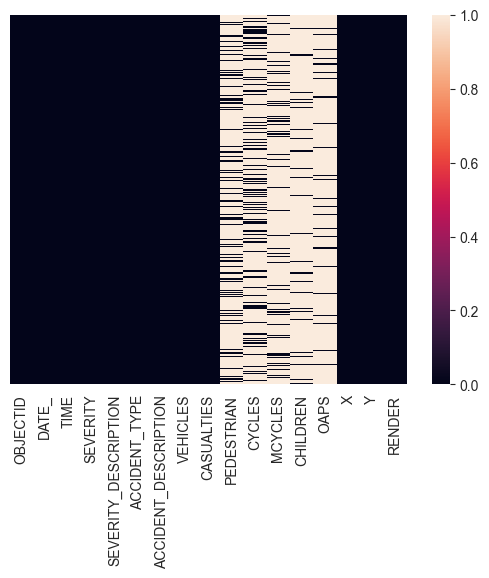

In [38]:
sns.heatmap(data == 0, yticklabels=False)

In [39]:
data.drop(['OBJECTID', 'DATE_', 'TIME', 'SEVERITY_DESCRIPTION', 'CASUALTIES', 'ACCIDENT_TYPE',
           'ACCIDENT_DESCRIPTION', 'X', 'Y', 'RENDER'], axis=1, inplace=True)
# converting fatal collisions to serious
data['SEVERITY'] = data['SEVERITY'].replace(1, 2)
data.head(3)

SEVERITY  VEHICLES  PEDESTRIAN  CYCLES  MCYCLES  CHILDREN  OAPS
0         3         2           0       1        1         0     0
1         3         2           0       1        0         0     0
2         3         2           0       1        0         0     0

In [40]:
slight = pd.get_dummies(data["SEVERITY"], dtype=int, drop_first=True)
data = pd.concat([data, slight], axis=1)
data.drop(['SEVERITY'], axis=1, inplace=True)
data.rename(columns={3: 'Severe'}, inplace=True)
# inverting the severe column
data['Severe'] = data['Severe'] ^ 1
data.head(30)


VEHICLES  PEDESTRIAN  CYCLES  MCYCLES  CHILDREN  OAPS  Severe
0          2           0       1        1         0     0       0
1          2           0       1        0         0     0       0
2          2           0       1        0         0     0       0
3          2           0       0        0         0     0       0
4          1           1       0        0         0     0       0
5          1           1       0        1         0     0       0
6          2           0       1        0         0     0       0
7          2           0       1        0         0     0       0
8          2           0       0        1         0     0       0
9          2           0       0        0         0     1       0
10         1           1       0        0         0     0       0
11         2           0       0        0         0     0       0
12         1           1       0        0         0     0       0
13         2           0       1        0         0     0       0
14         1           1       0        0         0     0       0
15         2           0       0        1         0     0       0
16         4           0       0        0         0     0       0
17         1           0       0        1         0     0       0
18         2           0       0        0         0     0       0
19         2           0       0        0         0     0       0
20         2           0       0        1         0     0       0
21         2           0       0        0         0     0       0
22         2           0       1        0         0     0       0
23         3           0       0        0         0     0       0
24         2           0       1        1         0     0       0
25         2           0       0        1         0     0       0
26         2           0       0        0         1     0       0
27         2           0       0        0         0     1       1
28         2           0       0        1         0     0       1
29         5           0       0        0         0     0       0

# Performance Evaluation Functions

In [41]:
def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], "bs")
    plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$Age$", fontsize=15)
    plt.ylabel(r"$Glucose$", fontsize=15, rotation=90)

In [42]:
results = []


def add_results(result):
    results.append(result)


def get_results():
    print("Model, Test Avg. Accuracy, Test Avg. Precision")
    return results

In [43]:
def evaluate_model(model):
    y_pred = model.predict(X_test)
    matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    accu_score = accuracy_score(y_test, y_pred)
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1)
    print("\nConfusion Matrix:")
    print(matrix)
    print("\nClassification Report:")
    print(class_report)
    print("\nAccuracy Score")
    print(accu_score)
    print("\n")
    print('\nAverage accuracy: ', np.mean(scores))

    # doing k fold cross validation for precision
    scores_test = cross_val_score(model, X_test, y_test, scoring='accuracy', cv=10, n_jobs=-1)

    print('\nTest average accuracy: ', np.mean(scores_test))

    scores = cross_val_score(model, X_train, y_train, scoring='precision_macro', cv=10, n_jobs=-1)
    # print the average score
    print('\nAverage precision: ', scores.mean())

    # doing k fold cross validation for accuracy
    scores_test = cross_val_score(model, X_test, y_test, scoring='precision_macro', cv=10, n_jobs=-1)

    print('\nTest average precision: ', scores_test.mean())

<h1> Splitting dataset </h1>

In [44]:
X = data.drop(['Severe'], axis=1)
y = data['Severe']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

<h1> Support Vector Machine </h1>

In [53]:
linear_svm_model = SVC(kernel='linear')
linear_svm_pipeline = make_pipeline(StandardScaler(), linear_svm_model)

poly_svm_model = SVC(kernel='poly')
poly_svm_pipeline = make_pipeline(StandardScaler(), poly_svm_model)

rbf_svm_model = SVC(kernel='rbf')
rbf_svm_pipeline = make_pipeline(StandardScaler(), rbf_svm_model)


In [54]:
linear_svm_pipeline.fit(X_train, y_train)
poly_svm_pipeline.fit(X_train, y_train)
rbf_svm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

In [47]:
print("Linear Support Vector Machine:")
evaluate_model(model=linear_svm_pipeline)

Linear Support Vector Machine:


C:\Users\William Forber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\William Forber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\William Forber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi


Confusion Matrix:
[[1160    0]
 [ 120    0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1160
           1       0.00      0.00      0.00       120

    accuracy                           0.91      1280
   macro avg       0.45      0.50      0.48      1280
weighted avg       0.82      0.91      0.86      1280


Accuracy Score
0.90625



Average accuracy:  0.9048595991111311

Test average accuracy:  0.90625

Average precision:  0.45242979955556556

Test average precision:  0.453125


In [48]:
print("Polynomial Support Vector Machine:")
evaluate_model(model=poly_svm_pipeline)

Polynomial Support Vector Machine:


C:\Users\William Forber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\William Forber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\William Forber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi


Confusion Matrix:
[[1160    0]
 [ 120    0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1160
           1       0.00      0.00      0.00       120

    accuracy                           0.91      1280
   macro avg       0.45      0.50      0.48      1280
weighted avg       0.82      0.91      0.86      1280


Accuracy Score
0.90625



Average accuracy:  0.9038551323202622

Test average accuracy:  0.90390625

Average precision:  0.4775170184785008

Test average precision:  0.45301427165354335


In [49]:
print("Radial Basis Function Support Vector Machine:")
evaluate_model(model=rbf_svm_pipeline)

Radial Basis Function Support Vector Machine:

Confusion Matrix:
[[1159    1]
 [ 120    0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1160
           1       0.00      0.00      0.00       120

    accuracy                           0.91      1280
   macro avg       0.45      0.50      0.48      1280
weighted avg       0.82      0.91      0.86      1280


Accuracy Score
0.90546875



Average accuracy:  0.9048595991111311

Test average accuracy:  0.90546875

Average precision:  0.45242979955556556

Test average precision:  0.4530880905511811


<h1> Hyperparameter Tuning: </h1>

<h2> Linear Kernel Tuning: </h2>

Finding best class weight:

In [55]:
parameter_grid = {'class_weight': [{0: 1, 1: w} for w in np.linspace(1, 50, dtype=int)]}  # Different class weights
grid_search = GridSearchCV(estimator=linear_svm_model, param_grid=parameter_grid, scoring='precision', n_jobs=- 1)
grid_search.fit(X_train, y_train)
print("Best Parameters", grid_search.best_params_)

Best Parameters {'class_weight': {0: 1, 1: 7}}


<p> Narrowing Down on best C hyper parameter </p>

In [58]:
linear_svm_model = SVC(kernel='linear', class_weight={0: 1, 1: 7})
linear_svm_model.fit(X_train, y_train)

parameter_grid = {'C': [0.001, 0.01, 0.1, 1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(estimator=linear_svm_model, param_grid=parameter_grid, scoring='precision', n_jobs=- 1)
grid_search.fit(X_train, y_train)
print("Best Parameters", grid_search.best_params_)

Best Parameters {'C': 10}


In [59]:
parameter_grid = {'C': np.linspace(1, 100, num=100, dtype=float)}
grid_search = GridSearchCV(estimator=linear_svm_model, param_grid=parameter_grid, scoring='precision', n_jobs=- 1)
grid_search.fit(X_train, y_train)
print("Best Parameters", grid_search.best_params_)

Best Parameters {'C': 77.0}


Best hyper parameters for linear kernel is 77 for the C hyper parameter

<h2> Polynomial kernel tuning: </h2>

Finding best class weight:

In [60]:
parameter_grid = {'class_weight': [{0: 1, 1: w} for w in np.linspace(1, 50, dtype=int)]}  # Different class weights
grid_search = GridSearchCV(estimator=poly_svm_model, param_grid=parameter_grid, scoring='precision', n_jobs=- 1)
grid_search.fit(X_train, y_train)
print("Best Parameters", grid_search.best_params_)

Best Parameters {'class_weight': {0: 1, 1: 5}}


In [61]:
poly_svm_model = SVC(kernel='poly', class_weight={0: 1, 1: 5})
poly_svm_model.fit(X_train, y_train)

parameter_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(estimator=poly_svm_model, param_grid=parameter_grid, scoring='precision', cv=3, n_jobs=- 1)
grid_search.fit(X_train, y_train)
print("Best Parameters", grid_search.best_params_)

KeyboardInterrupt: 

In [67]:
poly_svm_model = SVC(kernel='poly', class_weight='balanced', C=1000)
poly_svm_model.fit(X_train, y_train)

SVC(C=1000, class_weight='balanced', kernel='poly')

In [68]:
parameter_grid = {'degree': [1, 2, 3, 4, 5]}
grid_search = GridSearchCV(estimator=poly_svm_model, param_grid=parameter_grid, scoring='precision', cv=3, n_jobs=- 1)
grid_search.fit(X_train, y_train)
print("Best Parameters", grid_search.best_params_)

Best Parameters {'degree': 1}


In [13]:
poly_svm_model = SVC(kernel='poly', class_weight='balanced', C=1000, degree=1)
poly_svm_model.fit(X_train, y_train)
parameter_grid = {'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(estimator=poly_svm_model, param_grid=parameter_grid, scoring='precision', cv=3, n_jobs=- 1)
grid_search.fit(X_train, y_train)
print("Best Parameters", grid_search.best_params_)

Best Parameters {'gamma': 0.01}


In [15]:
parameter_grid = {'gamma': np.linspace(0.001, 0.01, num=100, dtype=float)}
grid_search = GridSearchCV(estimator=poly_svm_model, param_grid=parameter_grid, scoring='precision', cv=3, n_jobs=- 1)
grid_search.fit(X_train, y_train)
print("Best Parameters", grid_search.best_params_)

Best Parameters {'gamma': 0.0019090909090909093}


\The best hyperparameters found for the polynomial kernel are: 
C = 1000
degree = 1
gamma = 0.00191


<h2> Radial Basis Function kernel tuning: </h2>

In [16]:
parameter_grid = {'C': [0.01, 0.1, 1, 1, 10, 100, 1000], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(estimator=rbf_svm_model, param_grid=parameter_grid, scoring='precision', cv=3, n_jobs=- 1)
grid_search.fit(X_train, y_train)
print("Best Parameters", grid_search.best_params_)

Best Parameters {'C': 0.1, 'gamma': 10}


In [19]:
parameter_grid = {'C': np.linspace(0.01, 1, num=100, dtype=float)}
grid_search = GridSearchCV(estimator=rbf_svm_model, param_grid=parameter_grid, scoring='precision', cv=3, n_jobs=- 1)
grid_search.fit(X_train, y_train)
print("Best Parameters", grid_search.best_params_)

Best Parameters {'C': 0.59}


In [22]:
rbf_svm_model = SVC(kernel='rbf', class_weight='balanced', C=0.59)
rbf_svm_model.fit(X_train, y_train)
parameter_grid = {'gamma': np.linspace(0.1, 10, num=100, dtype=float)}
grid_search = GridSearchCV(estimator=rbf_svm_model, param_grid=parameter_grid, scoring='precision', cv=3, n_jobs=- 1)
grid_search.fit(X_train, y_train)
print("Best Parameters", grid_search.best_params_)

Best Parameters {'gamma': 0.30000000000000004}


The best hyperparameters found for the Radial Basis Function Kernel are: C = 0.59, gamma = 0.30

<h1> Tuned Support Vector Machine Model Evaluation: </h1>

In [23]:
linear_svm_model = SVC(kernel='linear', class_weight='balanced', C=404.44)
linear_svm_pipeline = make_pipeline(StandardScaler(), linear_svm_model)

poly_svm_model = SVC(kernel='poly', class_weight='balanced', C=1000, degree=1, gamma=0.001909)
poly_svm_pipeline = make_pipeline(StandardScaler(), poly_svm_model)

rbf_svm_model = SVC(kernel='rbf', class_weight='balanced', C=0.59, gamma=0.30)
rbf_svm_pipeline = make_pipeline(StandardScaler(), rbf_svm_model)

In [24]:
linear_svm_pipeline.fit(X_train, y_train)
poly_svm_pipeline.fit(X_train, y_train)
rbf_svm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=0.59, class_weight='balanced', gamma=0.3))])

In [25]:
print("Tuned Linear Support Vector Machine:")
evaluate_model(model=linear_svm_pipeline)

Tuned Linear Support Vector Machine:

Confusion Matrix:
[[ 64  56]
 [351 809]]

Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.53      0.24       120
           1       0.94      0.70      0.80      1160

    accuracy                           0.68      1280
   macro avg       0.54      0.62      0.52      1280
weighted avg       0.86      0.68      0.75      1280


Accuracy Score
0.68203125



Average accuracy:  0.6576216022087047

Test average accuracy:  0.6859375

Average precision:  0.5313142165211819

Test average precision:  0.5394655316501651


In [26]:
print("Tuned Polynomial Support Vector Machine:")
evaluate_model(model=poly_svm_pipeline)

Tuned Polynomial Support Vector Machine:

Confusion Matrix:
[[ 64  56]
 [351 809]]

Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.53      0.24       120
           1       0.94      0.70      0.80      1160

    accuracy                           0.68      1280
   macro avg       0.54      0.62      0.52      1280
weighted avg       0.86      0.68      0.75      1280


Accuracy Score
0.68203125



Average accuracy:  0.6582961100760926

Test average accuracy:  0.715625

Average precision:  0.5315371491657106

Test average precision:  0.536853457044393


In [27]:
print("Tuned Radial Basis Function Support Vector Machine:")
evaluate_model(model=rbf_svm_pipeline)

Tuned Radial Basis Function Support Vector Machine:

Confusion Matrix:
[[ 73  47]
 [368 792]]

Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.61      0.26       120
           1       0.94      0.68      0.79      1160

    accuracy                           0.68      1280
   macro avg       0.55      0.65      0.53      1280
weighted avg       0.87      0.68      0.74      1280


Accuracy Score
0.67578125



Average accuracy:  0.6643262777490965

Test average accuracy:  0.6578125

Average precision:  0.5382747435590717

Test average precision:  0.5468479342349335


Overall the support vector machine with the radial basis function kernel performed the best once tuned over all the other kernels.
With the average accuracy and test average accuracy greater than any other kernel.
However, all models suffered with poor precision.

<h1> Ensemble model testing: </h1>

In [56]:
ensemble_model = RandomForestClassifier(random_state=0, class_weight='balanced', n_jobs=-1)
ensemble_pipe_line = make_pipeline(StandardScaler(), ensemble_model)
ensemble_pipe_line.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                        random_state=0))])

In [57]:
evaluate_model(ensemble_pipe_line)


Confusion Matrix:
[[ 72  48]
 [370 790]]

Classification Report:
              precision    recall  f1-score   support

           0       0.16      0.60      0.26       120
           1       0.94      0.68      0.79      1160

    accuracy                           0.67      1280
   macro avg       0.55      0.64      0.52      1280
weighted avg       0.87      0.67      0.74      1280


Accuracy Score
0.6734375



Average accuracy:  0.6639907072792979

Test average accuracy:  0.65546875

Average precision:  0.5409800013492475

Test average precision:  0.5476270688131093


<h2> Untuned ensemble results: </h2>

On the surface the default ensemble model looks good however the low precision suggests that the model is overfit to slight accidents, so the hyperparameters need to be tuned.

<h2> Tuning ensemble hyperparameters: </h2> 

In [59]:
parameter_grid = {'max_features': [1, 2, 3, 4, 5],
                  'max_samples': [1, 10, 100, 500]}
grid_search = GridSearchCV(estimator=ensemble_model, param_grid=parameter_grid, scoring='precision', cv=3, n_jobs=- 1)
grid_search.fit(X_train, y_train)
print("Best Parameters", grid_search.best_params_)

Best Parameters {'max_features': 3, 'max_samples': 100}


In [60]:
parameter_grid = {'max_features': [1, 2, 3, 4, 5],
                  'max_samples': np.linspace(10, 500, num=490, dtype=int)}
grid_search = GridSearchCV(estimator=ensemble_model, param_grid=parameter_grid, scoring='precision', cv=3, n_jobs=- 1)
grid_search.fit(X_train, y_train)
print("Best Parameters", grid_search.best_params_)

Best Parameters {'max_features': 4, 'max_samples': 62}


In [63]:
ensemble_model = RandomForestClassifier(random_state=0, class_weight='balanced', max_features=4, max_samples=62,
                                        n_jobs=-1)
ensemble_pipe_line = make_pipeline(StandardScaler(), ensemble_model)
ensemble_pipe_line.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', max_features=4,
                                        max_samples=62, n_jobs=-1,
                                        random_state=0))])

In [64]:
evaluate_model(ensemble_pipe_line)


Confusion Matrix:
[[ 70  50]
 [361 799]]

Classification Report:
              precision    recall  f1-score   support

           0       0.16      0.58      0.25       120
           1       0.94      0.69      0.80      1160

    accuracy                           0.68      1280
   macro avg       0.55      0.64      0.52      1280
weighted avg       0.87      0.68      0.74      1280


Accuracy Score
0.67890625



Average accuracy:  0.5855962829117192

Test average accuracy:  0.58515625

Average precision:  0.535769652982788

Test average precision:  0.5376292280305452
